# Описание проекта

<p>Существует приложение «Ненужные вещи» в котором пользователи продают свои ненужные вещи, размещая их на доске объявлений.  </p>
<p> От меня, как от аналитика сервиса, требуется поработать с данными, чтобы проанализировать, как поведение пользователей изменяется во времени, каковы показатели метрик пользователей, и, посмотреть в целом, на что мы можем сделать упор, для улучшения сервиса.</p>
<p>В этой работе мы:</p>
<ol> 
<li>Проведем анализ метрик пользователей:</li>
    <ul>
    <li>Рассчитаем удержание по когортам, построим тепловую карту и график удержания;</li>
    <li>Рассчитаем общее время, проведённое пользователем в приложении и выделим сессии;</li>
    <li>Посмотрим частоту совершения событий и посмотреть как пользователи себя ведут в разрезе недели;</li>
    <li>Рассчитаем конверсию в целевое действие в целом и в разрезе различных сегментов.</li>
    </ul>
<li>Проведем сегментацию:</li>
    <ul>
    <li>Разделим пользователей на группы по источнику (yandex, google, other);</li>
    <li>Посмотрим, у какой группы лучше показатели по retention rate;</li>
    <li>Посмотрим, у какой группы лучше показатели по конверсии.</li>
    </ul>
<li>Выведем и проверим гипотезы:</li>
    <ul>
    <li>Гипотеза о различии конверсий для пользователей из Yandex и Google.</li>
    <li>Пользователи с разным количеством сессий демонстрируют разную конверсию.</li>
    </ul>
<ol>

## Выгрузка данных

<b>Импортируем необходимые библиотеки

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import math as mth
from scipy import stats as st
from statsmodels.stats.multitest import multipletests

<b>Откроем файл с данными и изучим общую информацию

In [7]:
df = pd.read_csv('mobile_dataset.csv')
df.head()

event.time   event.name  \
0  2019-10-07 00:00:00.431357  advert_open   
1  2019-10-07 00:00:01.236320    tips_show   
2  2019-10-07 00:00:02.245341    tips_show   
3  2019-10-07 00:00:07.039334    tips_show   
4  2019-10-07 00:00:56.319813  advert_open   

                                user.id  
0  020292ab-89bc-4156-9acf-68bc2783f894  
1  020292ab-89bc-4156-9acf-68bc2783f894  
2  cf7eda61-9349-469f-ac27-e5b6f5ec475c  
3  020292ab-89bc-4156-9acf-68bc2783f894  
4  cf7eda61-9349-469f-ac27-e5b6f5ec475c

In [8]:
src = pd.read_csv('mobile_sourсes.csv')
src.head()

userId  source
0  020292ab-89bc-4156-9acf-68bc2783f894   other
1  cf7eda61-9349-469f-ac27-e5b6f5ec475c  yandex
2  8c356c42-3ba9-4cb6-80b8-3f868d0192c3  yandex
3  d9b06b47-0f36-419b-bbb0-3533e582a6cb   other
4  f32e1e2a-3027-4693-b793-b7b3ff274439  google

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   event.time  74197 non-null  object
 1   event.name  74197 non-null  object
 2   user.id     74197 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB


In [10]:
src.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4293 entries, 0 to 4292
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   userId  4293 non-null   object
 1   source  4293 non-null   object
dtypes: object(2)
memory usage: 67.2+ KB


## Предобработка данных

<b>Приведем столбцы к общему виду

In [13]:
df = df.rename(columns = {'event.time':'event_time', 'event.name':'event_name', 'user.id':'user_id'})
df.columns

Index(['event_time', 'event_name', 'user_id'], dtype='object')

In [14]:
src = src.rename(columns = {'userId':'user_id'})
src.columns

Index(['user_id', 'source'], dtype='object')

<b>Пропишем подходящие типы

In [16]:
df['event_time'] = pd.to_datetime(df['event_time'])

<b>Объединим датасеты в один

In [18]:
data = pd.merge(df, src, on='user_id', how='left')
data.head() 

event_time   event_name  \
0 2019-10-07 00:00:00.431357  advert_open   
1 2019-10-07 00:00:01.236320    tips_show   
2 2019-10-07 00:00:02.245341    tips_show   
3 2019-10-07 00:00:07.039334    tips_show   
4 2019-10-07 00:00:56.319813  advert_open   

                                user_id  source  
0  020292ab-89bc-4156-9acf-68bc2783f894   other  
1  020292ab-89bc-4156-9acf-68bc2783f894   other  
2  cf7eda61-9349-469f-ac27-e5b6f5ec475c  yandex  
3  020292ab-89bc-4156-9acf-68bc2783f894   other  
4  cf7eda61-9349-469f-ac27-e5b6f5ec475c  yandex

### Проверка на дубликаты

In [20]:
df.duplicated().sum()

0

In [21]:
src.duplicated().sum()

0

In [22]:
data.duplicated().sum()

0

Дубликатов нет

<b>Проверим неочевидные дубликаты

In [25]:
data['event_name'].unique()

array(['advert_open', 'tips_show', 'map', 'contacts_show', 'search_4',
       'search_5', 'tips_click', 'photos_show', 'search_1', 'search_2',
       'search_3', 'favorites_add', 'contacts_call', 'search_6',
       'search_7', 'show_contacts'], dtype=object)

"contacts_show" и "show_contacts" являются по сути одним и тем же, но записанным по разному.<br>
Сведем все к одному столбцу.

In [27]:
data['event_name'] = data['event_name'].replace('show_contacts', 'contacts_show')

### Проверка на пропуски

In [29]:
data.isna().sum()

event_time    0
event_name    0
user_id       0
source        0
dtype: int64

In [30]:
src.isna().sum()

user_id    0
source     0
dtype: int64

Пропусков нет

## Анализ метрик пользователей

### Retention rate
Рассчитаем retention rate по когортам (например, на основе даты первого действия).

In [34]:
# Определяем даты первого действия для каждого пользователя
data['first_event_date'] = data.groupby('user_id')['event_time'].transform('min').dt.normalize()

# Вычисление времени с даты первого события в днях
data['event_date'] = data['event_time'].dt.normalize()
data['days_since_first_event'] = (data['event_date'] - data['first_event_date']).dt.days

# Подсчет уникальных пользователей по когортам и дням
cohorts = (
    data.groupby(['first_event_date', 'days_since_first_event'])['user_id']
    .nunique()
    .reset_index()
    .rename(columns={'user_id': 'active_users'})
)

# Подсчет числа пользователей в каждой когорте (день 0)
cohort_sizes = (
    cohorts[cohorts['days_since_first_event'] == 0][['first_event_date', 'active_users']]
    .rename(columns={'active_users': 'cohort_size'})
)

# Добавление размера когорты для расчета Retention Rate
cohorts = cohorts.merge(cohort_sizes, on='first_event_date')

# Расчет Retention Rate
cohorts['retention_rate'] = cohorts['active_users'] / cohorts['cohort_size'] * 100

# Форматирование данных для удобного анализа (матрица когорт)
retention_matrix = cohorts.pivot(index='first_event_date', columns='days_since_first_event', values='retention_rate')

# Вывод результата
#display(retention_matrix)

<b>Построим тепловую карту в когортах по дням

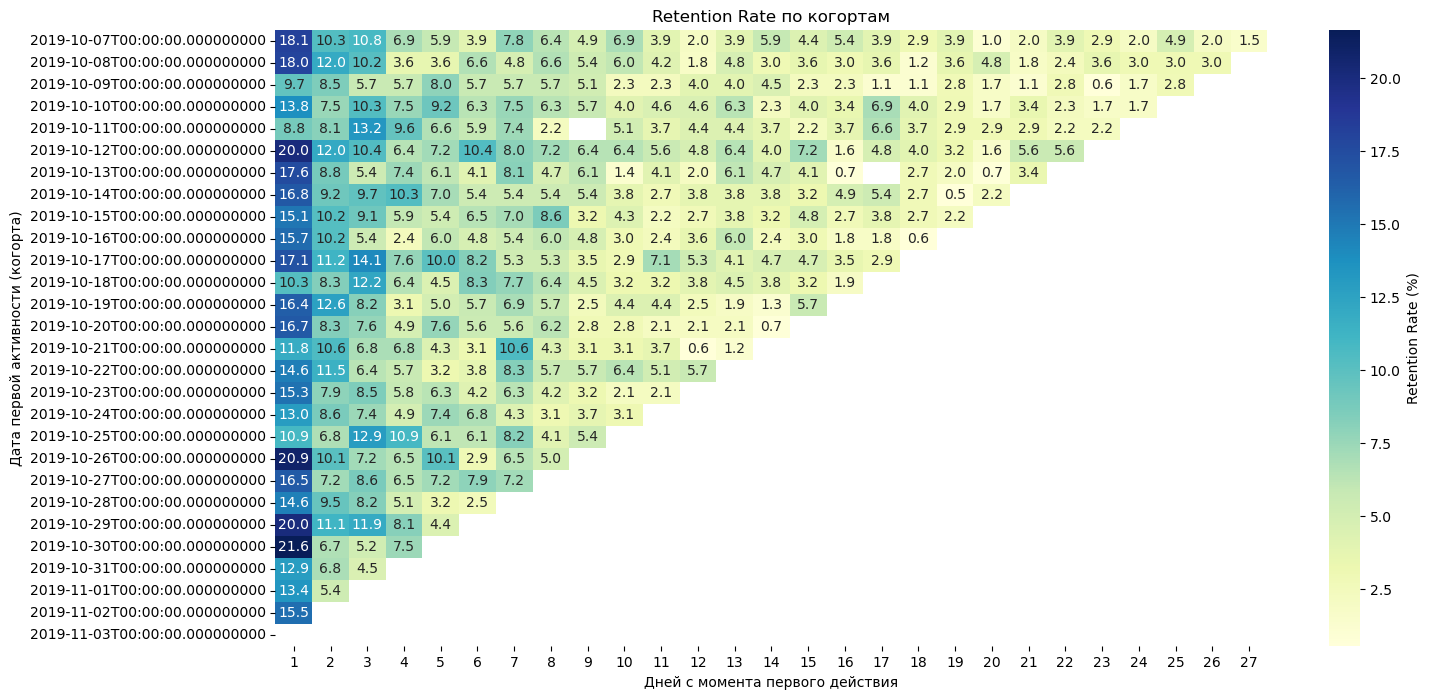

In [36]:
# Уберем 0-й день, чтобы не искажать визуализацию цветовой шкалы
retention_matrix = retention_matrix.drop(columns=0, errors='ignore')

# Строим тепловую карты
plt.figure(figsize=(16, 8))
sns.heatmap(
    retention_matrix,
    annot=True,  # Отображаем значения в ячейках
    fmt=".1f",  # Формат значений (1 знак после запятой)
    cmap="YlGnBu",  # Цветовая палитра
    cbar_kws={'label': 'Retention Rate (%)'}
)
plt.title('Retention Rate по когортам')
plt.xlabel('Дней с момента первого действия')
plt.ylabel('Дата первой активности (когорта)')
#plt.xticks(rotation=45)  # Поворачиваем подписи столбцов для удобства
#plt.yticks(rotation=0)
plt.show()

<b>Построим график удержания

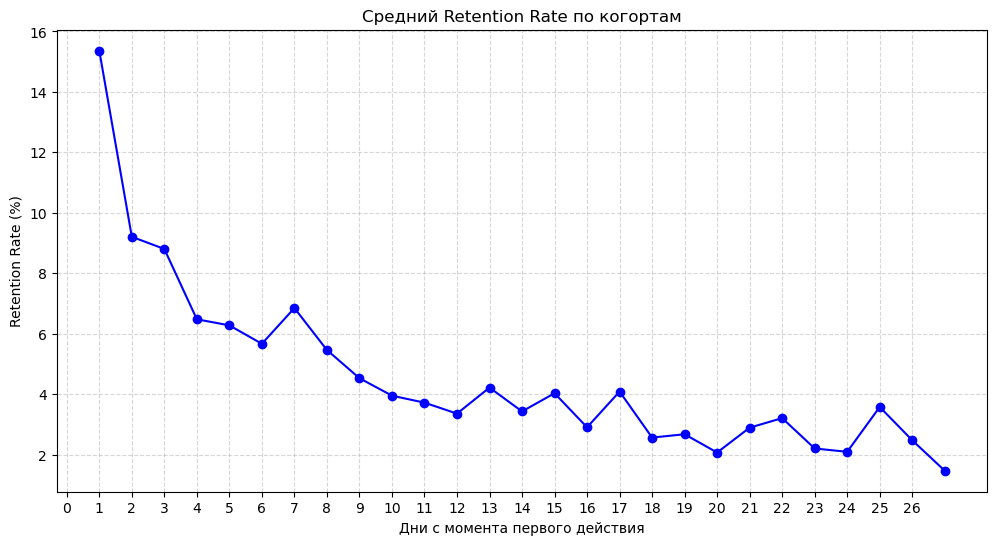

In [38]:
# Рассчитаем среднее удержание по всем когортам для каждого дня
average_retention = retention_matrix.mean(axis=0)

# Построим график
plt.figure(figsize=(12, 6))
plt.plot(average_retention.index, average_retention.values, marker='o', linestyle='-', color='b')
plt.title('Средний Retention Rate по когортам')
plt.xlabel('Дни с момента первого действия')
plt.ylabel('Retention Rate (%)')
plt.xticks(ticks=range(0, len(average_retention.index)))
plt.grid(visible=True, linestyle='--', alpha=0.5)
plt.show()

Мы видим, что в среднем доля удержания падает на половину на второй же день. На 4-й день происходит еще один резкий спад, после чего на 7-й день наблюдается постепенное снижение. После 12-го дня график колеблется до конца, но остается в пределах 2-4%.

### Время в приложении

<b>Рассчитаем общее время, проведённое пользователем в приложении (разница между временем последнего и первого события).

In [42]:
# Находим время первого и последнего события для каждого пользователя
user_time = data.groupby('user_id')['event_time'].agg(['min', 'max']).reset_index()

# Рассчитываем разницу между последним и первым событием
user_time['total_time'] = (user_time['max'] - user_time['min']).dt.total_seconds() / 60 # переводим в минуты

# Переименовываем столбцы для ясности
user_time.columns = ['user_id', 'first_event', 'last_event', 'total_time']

user_time.head()

user_id                first_event  \
0  0001b1d5-b74a-4cbf-aeb0-7df5947bf349 2019-10-07 13:39:45.989359   
1  00157779-810c-4498-9e05-a1e9e3cedf93 2019-10-19 21:34:33.849769   
2  00463033-5717-4bf1-91b4-09183923b9df 2019-11-01 13:54:35.385028   
3  004690c3-5a84-4bb7-a8af-e0c8f8fca64e 2019-10-18 22:14:05.555052   
4  00551e79-152e-4441-9cf7-565d7eb04090 2019-10-25 16:44:41.263364   

                  last_event    total_time  
0 2019-10-22 11:30:52.807203  21471.113631  
1 2019-11-03 17:12:09.708771  21337.597650  
2 2019-11-01 14:19:17.860053     24.707917  
3 2019-10-31 21:42:15.606558  18688.167525  
4 2019-10-29 02:17:12.342406   4892.517984

<b>Выделим сессии пользователей

In [44]:
# Добавляем колонку с датой события (без времени)
data['event_date'] = data['event_time'].dt.date

# Группируем по пользователю и дате, считая количество событий в день
user_sessions = data.groupby(['user_id', 'event_date'])['event_name'].count().reset_index(name='events_per_session')


# Подсчитываем общее количество сессий для каждого пользователя
user_sessions_count = user_sessions.groupby('user_id')['event_date'].count().reset_index(name='total_sessions')

display(user_sessions.head())
display(user_sessions_count.head())

user_id  event_date  events_per_session
0  0001b1d5-b74a-4cbf-aeb0-7df5947bf349  2019-10-07                   9
1  0001b1d5-b74a-4cbf-aeb0-7df5947bf349  2019-10-09                   4
2  0001b1d5-b74a-4cbf-aeb0-7df5947bf349  2019-10-21                  14
3  0001b1d5-b74a-4cbf-aeb0-7df5947bf349  2019-10-22                   8
4  00157779-810c-4498-9e05-a1e9e3cedf93  2019-10-19                   9

user_id  total_sessions
0  0001b1d5-b74a-4cbf-aeb0-7df5947bf349               4
1  00157779-810c-4498-9e05-a1e9e3cedf93               6
2  00463033-5717-4bf1-91b4-09183923b9df               1
3  004690c3-5a84-4bb7-a8af-e0c8f8fca64e               6
4  00551e79-152e-4441-9cf7-565d7eb04090               3

<b>Расчитаем время каждой сессии

In [46]:
# Рассчитываем время каждой сессии
session_times = data.groupby(['user_id', 'event_date'])['event_time'].agg(['min', 'max']).reset_index()

# Вычисляем длительность сессии
session_times['session_duration'] = (session_times['max'] - session_times['min']).dt.total_seconds() / 60  # переводим в минуты

# Оставляем только нужные колонки
session_times = session_times[['user_id', 'event_date', 'session_duration']]

display(session_times)

user_id  event_date  session_duration
0     0001b1d5-b74a-4cbf-aeb0-7df5947bf349  2019-10-07          9.928788
1     0001b1d5-b74a-4cbf-aeb0-7df5947bf349  2019-10-09          8.456433
2     0001b1d5-b74a-4cbf-aeb0-7df5947bf349  2019-10-21         14.987868
3     0001b1d5-b74a-4cbf-aeb0-7df5947bf349  2019-10-22         12.636196
4     00157779-810c-4498-9e05-a1e9e3cedf93  2019-10-19         25.346455
...                                    ...         ...               ...
7812  fffb9e79-b927-4dbb-9b48-7fd09b23a62b  2019-10-29        134.213606
7813  fffb9e79-b927-4dbb-9b48-7fd09b23a62b  2019-10-30        676.042053
7814  fffb9e79-b927-4dbb-9b48-7fd09b23a62b  2019-11-01          0.371839
7815  fffb9e79-b927-4dbb-9b48-7fd09b23a62b  2019-11-02       1094.025401
7816  fffb9e79-b927-4dbb-9b48-7fd09b23a62b  2019-11-03         95.490540

[7817 rows x 3 columns]

<b>Построим интерактивную диаграмму размаха по сессиям

count    7817.000000
mean       83.033370
std       190.168049
min         0.000000
25%         2.457990
50%        11.806934
75%        48.749509
max      1417.477773
Name: session_duration, dtype: float64

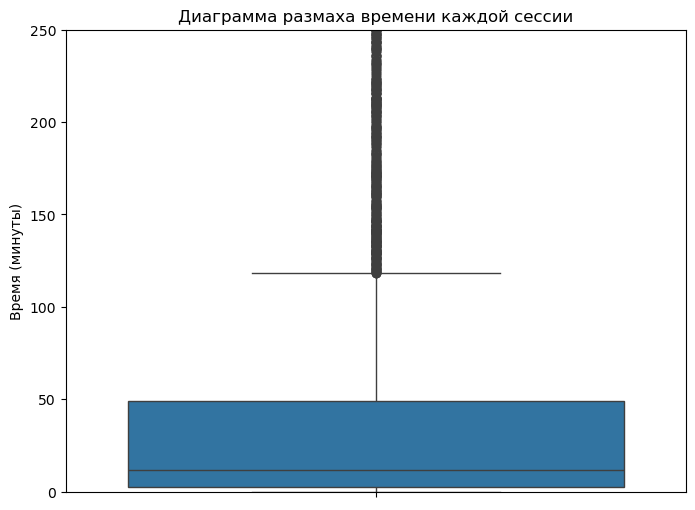

In [48]:
display(session_times['session_duration'].describe())

plt.figure(figsize=(8, 6))
sns.boxplot(y=session_times['session_duration'])
plt.title('Диаграмма размаха времени каждой сессии')
plt.ylabel('Время (минуты)')
plt.ylim(0, 250)

plt.show()

Как мы видим, медианное значение сессии составляет почти 12 минут.
Есть много аномалий, вплоть до 1417 минут (это 23 часа 37 минут).

<b>Построим распределение времени по пользователям.

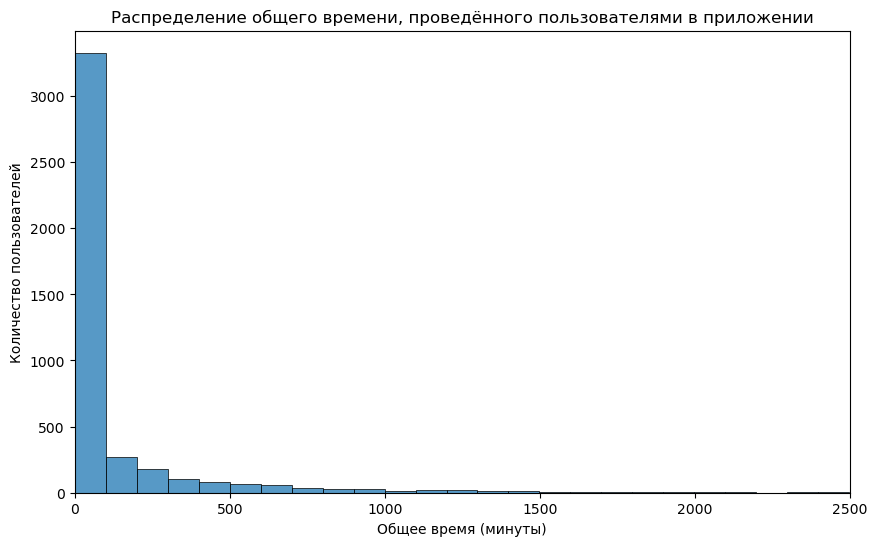

In [51]:
# Рассчитываем общее время, проведённое каждым пользователем в приложении
user_total_time = session_times.groupby('user_id')['session_duration'].sum().reset_index()
#display(user_total_time)
#display(user_time)

# Создаём гистограмму
plt.figure(figsize=(10, 6))
sns.histplot(user_total_time['session_duration'], bins=100, edgecolor='black')

plt.title('Распределение общего времени, проведённого пользователями в приложении')
plt.xlabel('Общее время (минуты)')
plt.ylabel('Количество пользователей')
plt.xlim(0, 2500)

plt.show()

<b>Сразу же построим диаграмму размаха

In [53]:
display(user_total_time['session_duration'].describe())

plt.figure(figsize=(8, 6))
sns.boxplot(y=user_total_time['session_duration'])
plt.title('Диаграмма размаха для общего времени, проведённого пользователями в приложении')
plt.ylabel('Общее время (минуты)')
plt.ylim(0, 250)

plt.show()

count    4293.000000
mean      151.193071
std       474.760168
min         0.000000
25%         7.334752
50%        21.588322
75%        80.385336
max      9992.856236
Name: session_duration, dtype: float64

Мы видим, что за имеющийся в нашем распоряжении период, большинство пользователей потратили в приложении около 50 минут. В среднем (медианное значение) пользователи потратили 21 минуту в приложении. Конечно же не обходится без аномалий, их тут много, и достигают они значений вплоть до 10000 минут.

<b>Проверяем, есть ли нулевые сессии

In [56]:
zero_sessions = session_times[session_times['session_duration'] == 0]
print("Количество нулевых сессий:", zero_sessions.shape[0])
print("Доля нулевых сессий от общего кол-ва сессий:", zero_sessions.shape[0]/session_times.shape[0])

Количество нулевых сессий: 994
Доля нулевых сессий от общего кол-ва сессий: 0.1271587565562236


<b>Анализируем полученные данные</b> 
- Сколько занимает среднее время сессий?
- Есть ли аномально длинные сессии?
- Есть ли нулевые сессии?

<b> Подведем итог:
- Среднее время сессии занимает около 20-25 минут.
- Есть аномально длинные сессии, вплоть до 1417 минут (23 часа 37 минут).
- Нулевые сесии есть, и они занимают порядка 12% от общего числа сессий.

### Частота совершения событий

<b>Подсчитаем общее количество действий для каждого пользователя.

In [61]:
user_event_count = data.groupby('user_id')['event_name'].count().reset_index(name='event_count')
user_event_count.head()

user_id  event_count
0  0001b1d5-b74a-4cbf-aeb0-7df5947bf349           35
1  00157779-810c-4498-9e05-a1e9e3cedf93           71
2  00463033-5717-4bf1-91b4-09183923b9df           10
3  004690c3-5a84-4bb7-a8af-e0c8f8fca64e           32
4  00551e79-152e-4441-9cf7-565d7eb04090            8

<b>Рассчитаем динамика суммы частоты событий по датам и построим график</b> <br>
    (например, 1 января - 10к событий, 2 января - 20к событий и т.д.)

In [63]:
# Группировка данных по дате и подсчёт количества событий
event_frequency = data.groupby('event_date')['event_name'].count().reset_index(name='event_count')

plt.figure(figsize=(12, 6))
plt.plot(event_frequency['event_date'], event_frequency['event_count'], marker='o', linestyle='-', color='royalblue')

plt.title('Динамика частоты событий по датам')
plt.xlabel('Дата')
plt.ylabel('Количество событий')
plt.xticks(rotation=45)  # Поворот подписей дат для читаемости
plt.grid(True, linestyle='--', alpha=0.6)  # Добавление сетки

plt.show()

Мы наблюдаем колеблящийся график. В целом, можно судить, что вторая половина октября была богатой на частоту событий.

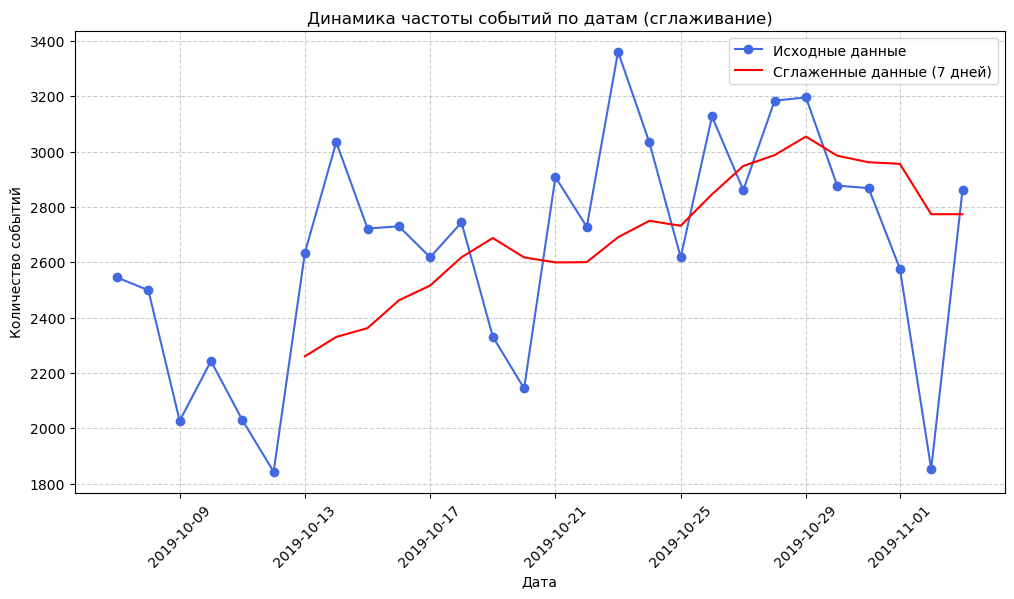

In [65]:
# Добавляем колонку со сглаженными значениями (скользящее среднее по 7 дням)
event_frequency['smoothed_event_count'] = event_frequency['event_count'].rolling(window=7).mean()

plt.figure(figsize=(12, 6))
plt.plot(event_frequency['event_date'], event_frequency['event_count'], marker='o', linestyle='-', color='royalblue', label='Исходные данные')
plt.plot(event_frequency['event_date'], event_frequency['smoothed_event_count'], linestyle='-', color='red', label='Сглаженные данные (7 дней)')

plt.title('Динамика частоты событий по датам (сглаживание)')
plt.xlabel('Дата')
plt.ylabel('Количество событий')
plt.xticks(rotation=45)  # Поворот подписей дат
plt.legend()  # Добавление легенды
plt.grid(True, linestyle='--', alpha=0.6)  # Добавление сетки

plt.show()

<b>Построим распределение частоты действий.

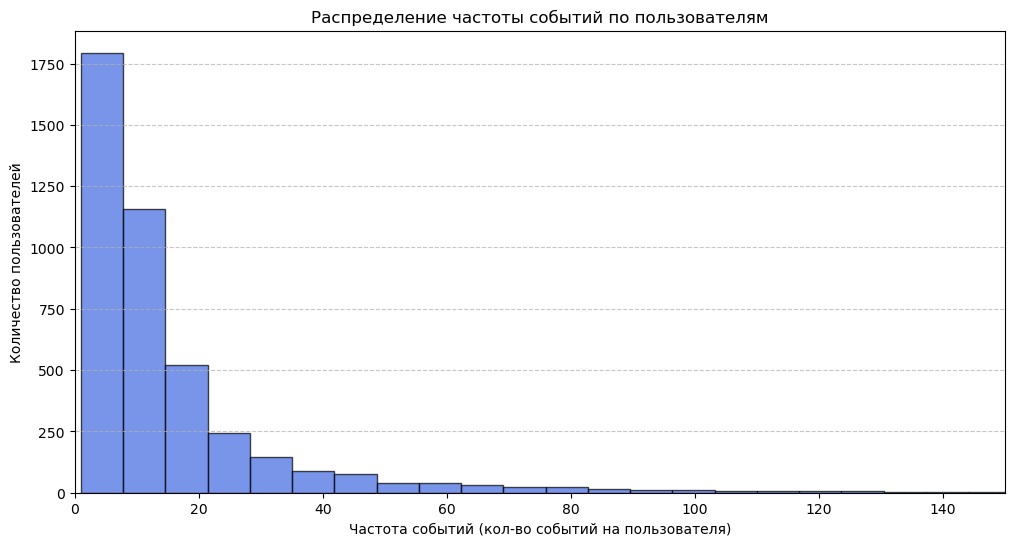

count    4293.000000
mean       17.283252
std        29.130677
min         1.000000
25%         5.000000
50%         9.000000
75%        17.000000
max       478.000000
Name: event_count, dtype: float64

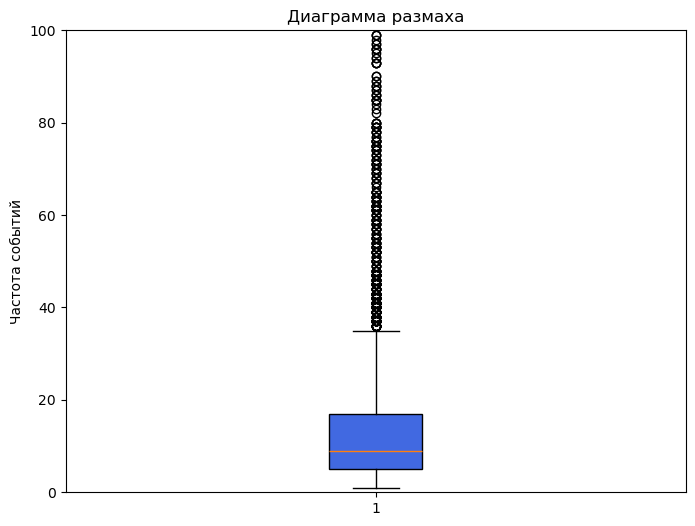

In [67]:
# Мы ранее считали в переменной user_event_count количество действий для каждого пользователя
# Гистограмма распределения частоты событий по пользователям
plt.figure(figsize=(12, 6))
plt.hist(user_event_count['event_count'], bins=70, color='royalblue', edgecolor='black', alpha=0.7)
plt.title('Распределение частоты событий по пользователям')
plt.xlabel('Частота событий (кол-во событий на пользователя)')
plt.ylabel('Количество пользователей')
plt.xlim(0, 150)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

display(user_event_count['event_count'].describe())
# Диаграмма размаха (boxplot)
plt.figure(figsize=(8, 6))
plt.boxplot(user_event_count['event_count'], vert=True, patch_artist=True, boxprops=dict(facecolor="royalblue"))
plt.title('Диаграмма размаха')
plt.ylabel('Частота событий')
plt.ylim(0, 100)

plt.show()

Из графиков видно, что на большинство пользователей приходится около 5-17 событий. С медианным значением 9 событий. Существует немало аномалий, где частота доходит вплоть до 478 событий на человека.

<b>Посмотрим как пользователи себя ведут в разрезе недели. Как они совершают действия в будни, а как в выходные дни?

In [70]:
# Добавим колонку с днем недели (0 - понедельник, 6 - воскресенье)
data['event_date'] = pd.to_datetime(data['event_date'])
data['day_of_week'] = data['event_date'].dt.dayofweek
#display(data)

# Категоризируем дни: 0-4 (будни), 5-6 (выходные)
data['week_category'] = data['day_of_week'].apply(
    lambda x: 'Будни' if x < 5 else 'Выходные'
)

# Считаем количество событий для каждой категории
actions_wc = data.groupby('week_category')['event_name'].count().reset_index(name='event_count')

# Считаем распределение событий по дням недели
actions_dow = data.groupby('day_of_week')['event_name'].count().reset_index(name='event_count')
actions_dow['day_of_week'] = actions_dow['day_of_week'].map({
    0: 'Понедельник', 1: 'Вторник', 2: 'Среда', 3: 'Четверг', 4: 'Пятница', 5: 'Суббота', 6: 'Воскресенье'
})

#display(actions_by_week_category)
#display(actions_by_day_of_week)

# Построение графика: распределение по дням недели
plt.figure(figsize=(10, 6))
plt.bar(actions_dow['day_of_week'], actions_dow['event_count'])
plt.title('Распределение активности пользователей по дням недели')
plt.xlabel('День недели')
plt.ylabel('Количество событий')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Отображение графика
plt.show()

Из результатов видно, что активность пользователей пиковая в понедельник, и с течением времени плавно спадает вплоть до субботы, после чего опять начинает расти, выходя на уровень показателей за середину недели. Нельзя выделить какие-то резкие различия в поведении пользователей по будням или по выходным, но можно предположить, что в субботу пользователи предпочитают больше отдыхать.

### Конверсия в целевое действие CONTACTS_SHOW

<b>Определим долю пользователей, которые совершили целевое действие (contacts_show или show_contacts).</b>

Ранее мы объединили пользователей с этими двумя целевыми действиями под одним действием contacts_show<br>
Напишем функцию, на случай, если захотим посмотреть конверсию по нескольким показателям.

In [75]:
def calculate_conversion(data):
    total_users = data['user_id'].nunique() 
    cs_count = data[data['event_name'].isin(['contacts_show'])]['user_id'].nunique() # кол-во пользователей дошедших до contacts_show
    if total_users == 0:
        return 0
    return (cs_count / total_users) * 100
print(f"Доля пользователей, посмотревших контакты: {calculate_conversion(data):.2f}%")

Доля пользователей, посмотревших контакты: 22.85%


<b>Рассчитаем конверсию в разрезе различных сегментов (например, по источникам установки или активности).

In [77]:
# Расчитаем конверсию по источникам и дате (динамика)
conversion_by_source_date = data.groupby(['source', 'event_date']).apply(calculate_conversion).reset_index(name='conversion_rate')

# Визуализируем
fig = px.line(conversion_by_source_date, x='event_date', y='conversion_rate', color='source',
              title='Динамика конверсии по источникам установки',
              labels={'conversion_rate': 'Конверсия (%)', 'event_date': 'Дата', 'source': 'Источник'})

fig.update_layout(xaxis_title="Дата", yaxis_title="Конверсия (%)", template='plotly_white')
fig.show()

C:\Users\midle\AppData\Local\Temp\ipykernel_19920\1472176206.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  conversion_by_source_date = data.groupby(['source', 'event_date']).apply(calculate_conversion).reset_index(name='conversion_rate')


C:\Users\midle\AppData\Local\Temp\ipykernel_19920\3267327917.py:2: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



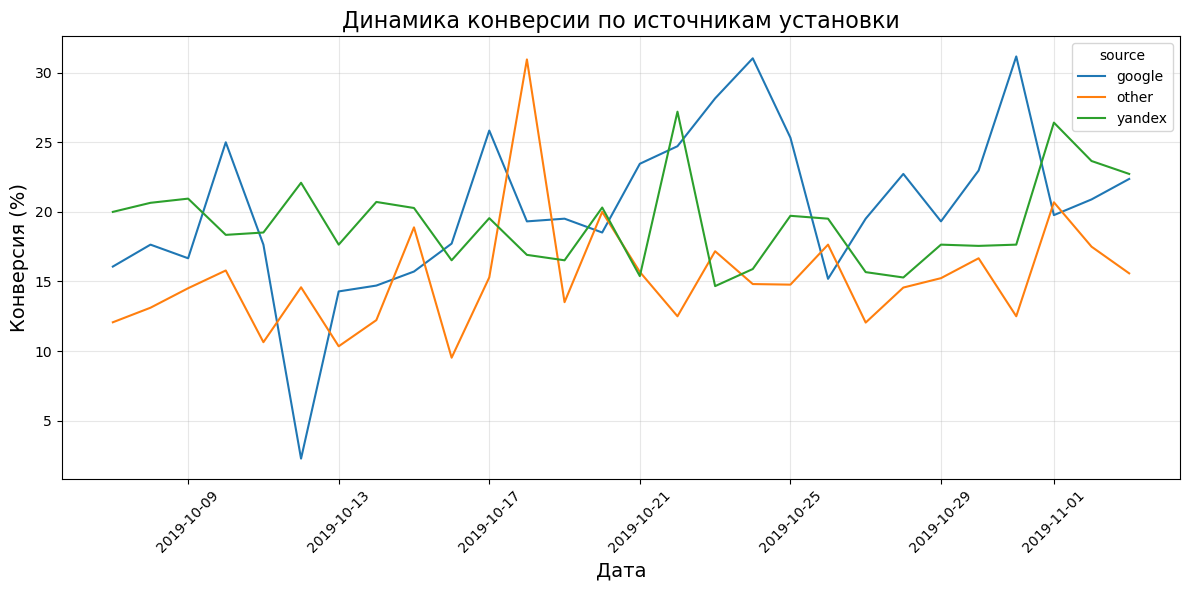

In [78]:
# Рассчитаем конверсию по источникам и дате (динамика)
conversion_by_source_date = data.groupby(['source', 'event_date']).apply(calculate_conversion).reset_index(name='conversion_rate')

# Визуализируем с использованием seaborn
plt.figure(figsize=(12, 6))  # Задаем размер графика
sns.lineplot(
    data=conversion_by_source_date,
    x='event_date',
    y='conversion_rate',
    hue='source',  
    palette='tab10'  
)

plt.title('Динамика конверсии по источникам установки', fontsize=16)
plt.xlabel('Дата', fontsize=14)
plt.ylabel('Конверсия (%)', fontsize=14)
plt.xticks(rotation=45)  
plt.grid(alpha=0.3)  

plt.tight_layout() 
plt.show()

По источнику yandex, в динамике, наблюдаются более-менее стабильные показатели конверсии, в то время, как остальные два источника сильно колеблются.

### Промежуточный итог:
- В среднем доля удержания падает на половину на второй же день. На 4-й день происходит еще один резкий спад, после чего на 7-й день наблюдается постепенное снижение. После 12-го дня график колеблется до конца, но остается в пределах 2-4%.
- Медианное значение сессии составляет почти 12 минут. Есть много аномалий, вплоть до 1417 минут (это 23 часа 37 минут).
- За имеющийся в нашем распоряжении период, большинство пользователей потратили в приложении около 50 минут. В среднем (медианное значение) пользователи потратили 21 минуту в приложении. Конечно же не обходится без аномалий, их тут много, и достигают они значений вплоть до 10000 минут.
- Мы наблюдаем колеблящийся график динамики частоты событий по датам. В целом, можно судить, что вторая половина октября была богатой на частоту событий.
- На большинство пользователей приходится около 5-17 событий. С медианным значением 9 событий. Существует немало аномалий, где частота доходит вплоть до 478 событий на человека.
- Активность пользователей пиковая в понедельник, и с течением времени плавно спадает вплоть до субботы, после чего опять начинает расти, выходя на уровень показателей за середину недели. Нельзя выделить какие-то резкие различия в поведении пользователей по будням или по выходным, но можно предположить, что в субботу пользователи предпочитают больше отдыхать.
- По источнику yandex, в динамике, наблюдаются более-менее стабильные показатели конверсии, в то время, как остальные два источника сильно колеблются.

## Сегментация

### Разделим пользователей на группы по источнику (yandex, google, other).

А также проверим, не пересекаются ли пользователи

In [84]:
# Сегментируем пользователей по источникам. Смотрим в src, поскольку датасет состоит из уникальных пользователей.
yandex_users = src[src['source'] == 'yandex']['user_id']
google_users = src[src['source'] == 'google']['user_id']
other_users = src[src['source'] == 'other']['user_id']

# Проверим на пересечения
yandex_google_intersection = set(yandex_users).intersection(google_users)
yandex_other_intersection = set(yandex_users).intersection(other_users)
google_other_intersection = set(google_users).intersection(other_users)


print(f"Количество пользователей из yandex: {len(yandex_users)}")
print(f"Количество пользователей из google: {len(google_users)}")
print(f"Количество пользователей из other: {len(other_users)}")

print(f"\nПересечение yandex и google: {len(yandex_google_intersection)} пользователей")
if len(yandex_google_intersection) > 0:
    print(f"Пересекающиеся user_id: {list(yandex_google_intersection)}")
    # Преобразуем в DataFrame для дальнейшего анализа
    df_yandex_google = pd.DataFrame(yandex_google_intersection, columns=['user_id'])
    print(f"DataFrame пересечения Yandex и Google:\n{df_yandex_google.head()}")
    
print(f"Пересечение yandex и other: {len(yandex_other_intersection)} пользователей")
if len(yandex_other_intersection) > 0:
    print(f"Пересекающиеся user_id: {list(yandex_other_intersection)}")
    df_yandex_other = pd.DataFrame(yandex_other_intersection, columns=['user_id'])
    print(f"DataFrame пересечения Yandex и Other:\n{df_yandex_other.head()}")

print(f"Пересечение google и other: {len(google_other_intersection)} пользователей")
if len(google_other_intersection) > 0:
    print(f"Пересекающиеся user_id: {list(google_other_intersection)}")
    df_google_other = pd.DataFrame(google_other_intersection, columns=['user_id'])
    print(f"DataFrame пересечения Google и Other:\n{df_google_other.head()}")

Количество пользователей из yandex: 1934
Количество пользователей из google: 1129
Количество пользователей из other: 1230

Пересечение yandex и google: 0 пользователей
Пересечение yandex и other: 0 пользователей
Пересечение google и other: 0 пользователей


Больше всего пользователей пришло из yandex, а меньше всего из google. Пользователи не пересекаются между источниками.

### У какой группы лучше показатели по retention rate

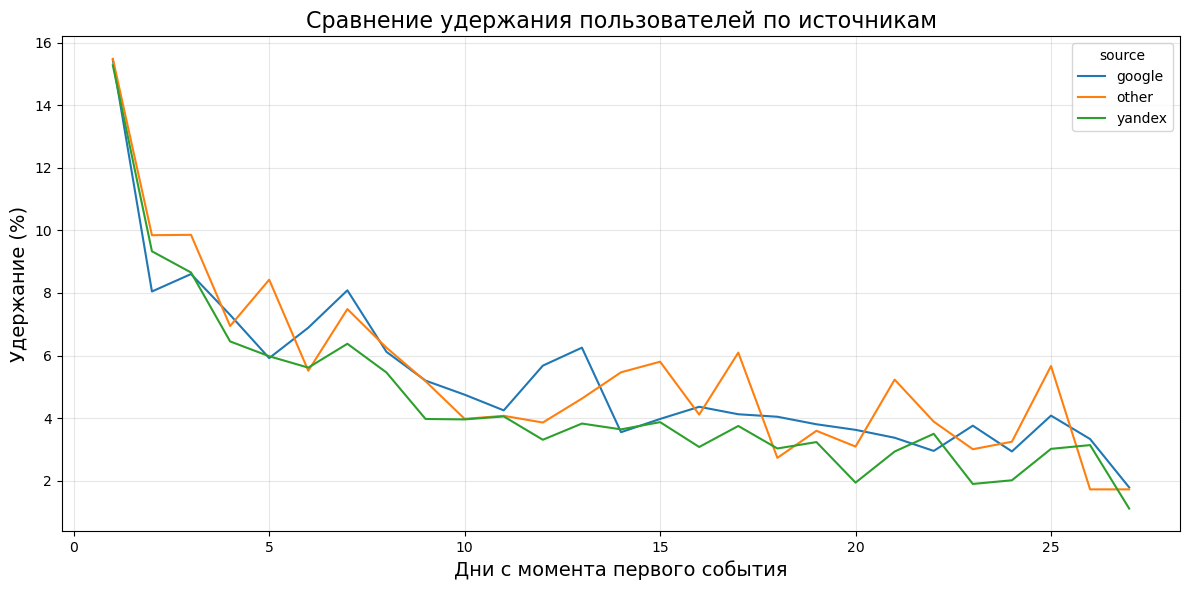

In [87]:
# Добавляем сегментацию по источникам
src['source'] = src['user_id'].apply(
    lambda user: 'yandex' if user in yandex_users else 'google' if user in google_users else 'other'
)

# Вычисляем когортный анализ с учетом источников
cohorts_with_source = (
    data.groupby(['source', 'first_event_date', 'days_since_first_event'])['user_id']
    .nunique()
    .reset_index()
    .rename(columns={'user_id': 'active_users'})
)

# Подсчет числа пользователей в каждой когорте (день 0) для каждого источника
cohort_sizes_with_source = (
    cohorts_with_source[cohorts_with_source['days_since_first_event'] == 0][['source', 'first_event_date', 'active_users']]
    .rename(columns={'active_users': 'cohort_size'})
)

# Добавляем размеры когорт для расчета Retention Rate
cohorts_with_source = cohorts_with_source.merge(cohort_sizes_with_source, on=['source', 'first_event_date'])

# Расчет Retention Rate с учетом источников
cohorts_with_source['retention_rate'] = cohorts_with_source['active_users'] / cohorts_with_source['cohort_size'] * 100

# Формируем матрицу когортного анализа по источникам
retention_matrices = {}
sources = cohorts_with_source['source'].unique()
for source in sources:
    retention_matrix = cohorts_with_source[cohorts_with_source['source'] == source] \
        .pivot(index='first_event_date', columns='days_since_first_event', values='retention_rate')
    retention_matrices[source] = retention_matrix

# Группируем данные для визуализации
retention_plot_data = cohorts_with_source.groupby(['source', 'days_since_first_event'])['retention_rate'].mean().reset_index()

# Убираем нулевой день из данных для графика
retention_plot_data_filtered = retention_plot_data[retention_plot_data['days_since_first_event'] != 0]

plt.figure(figsize=(12, 6))  
sns.lineplot(
    data=retention_plot_data_filtered,
    x='days_since_first_event',
    y='retention_rate',
    hue='source',  
    palette='tab10'
)

# Настройка заголовка и подписей
plt.title('Сравнение удержания пользователей по источникам', fontsize=16)
plt.xlabel('Дни с момента первого события', fontsize=14)
plt.ylabel('Удержание (%)', fontsize=14)
plt.grid(alpha=0.3)

plt.tight_layout()  # Улучшаем расположение элементов
plt.show()

Удержание пользователей по другим источникам имеет более высокие показатели. Однако с источником "google" он попеременно меняется в первенстве, на протяжении срока. Источник "yandex" показывает стабильно низкие показатели.

### У какой группы лучше показатели по конверсии

In [90]:
# Используем нашу функцию конверсии и рассчитываем конверсию по источникам установки
conversion_by_source = data.groupby('source').apply(calculate_conversion).reset_index(name='conversion_rate')
#display(conversion_by_source)

# Визуализация
plt.figure(figsize=(10, 6))  # Задаем размер графика
sns.barplot(
    data=conversion_by_source,
    x='source',
    y='conversion_rate',
    hue='source',  
    palette='tab10',  
    dodge=False,  # Все столбцы в одной группе
)

plt.title('Конверсия по источникам установки')
plt.xlabel('Источник установки')
plt.ylabel('Конверсия (%)')
plt.ylim(0, conversion_by_source['conversion_rate'].max() * 1.1)  # Устанавливаем диапазон оси Y

# Отображение значений на столбцах
for index, row in conversion_by_source.iterrows():
    plt.text(index, row['conversion_rate'], f"{row['conversion_rate']:.2f}%", 
             ha='center', va='bottom')

plt.tight_layout()
plt.show()

C:\Users\midle\AppData\Local\Temp\ipykernel_19920\2409568937.py:2: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



Лучшие показатели по конверсии у пользователей из yandex (24,7%), но пользователи из google не сильно от них отстают (24,3%). Самый низкий же показатель у пользователей из "других" источников (18,5%)

### Промежуточный итог:
- Больше всего пользователей пришло из yandex (1934), а меньше всего из google (1129).
- Удержание пользователей по другим источникам имеет более высокие показатели. Однако с источником "google" он попеременно меняется в первенстве, на протяжении срока. Источник "yandex" показывает стабильно низкие показатели.
- Лучшие показатели по конверсии у пользователей из yandex (24,7%), но пользователи из google не сильно от них отстают (24,3%). Самый низкий же показатель у пользователей из "других" источников (18,5%)

## Гипотезы

### Обязательная гипотеза
Гипотеза о различии конверсий для пользователей из Yandex и Google
- Нулевая гипотеза: Конверсии в просмотры контактов (действия contacts_show или show_contacts) одинаковы для пользователей, которые установили приложение через Yandex и Google.
- Альтернативная гипотеза: Конверсии в просмотры контактов отличаются для пользователей, которые установили приложение через Yandex и Google.

In [95]:
# Фильтруем данные для пользователей из Yandex и Google
yandex_data = data[data['user_id'].isin(yandex_users)]
google_data = data[data['user_id'].isin(google_users)]

# Подсчёт пользователей совершивших действие contacts_show (cs)
yandex_cs = yandex_data[yandex_data['event_name'] == 'contacts_show']['user_id'].nunique()
google_cs = google_data[google_data['event_name'] == 'contacts_show']['user_id'].nunique()

# Общее число пользователей в каждой группе
total_yandex_users = len(yandex_users)
total_google_users = len(google_users)

# Рассчитываем пропорции (конверсия)
p1 = yandex_cs / total_yandex_users
p2 = google_cs / total_google_users

# Объединённая пропорция успехов по обеим группам
p_combined = (yandex_cs + google_cs) / (total_yandex_users + total_google_users)

# Разница пропорций в датасетах
difference = p1 - p2

# Считаем статистику в ст. отклонениях стандартного нормального распределения
z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1 / total_yandex_users + 1 / total_google_users))

# Задаём стандартное нормальное распределение (среднее 0, ст. отклонение 1)
distr = st.norm(0, 1)

# Рассчитываем p-value
p_value = (1 - distr.cdf(abs(z_value))) * 2

# Уровень значимости
alpha = 0.05

# Вывод
print(f"Пропорция пользователей, совершивших действие contact_show в группе yandex: {p1:.2%}")
print(f"Пропорция пользователей, совершивших действие contact_show в группе google: {p2:.2%}")
print(f"p-value: {p_value:.4f}")

if p_value < alpha:
    print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
else:
    print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")

Пропорция пользователей, совершивших действие contact_show в группе yandex: 24.72%
Пропорция пользователей, совершивших действие contact_show в группе google: 24.36%
p-value: 0.8244
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


И действительно, мы наблюдаем, что конверсия в целевое действие отличается на сотые доли процентов между двумя главными источниками.

### Собственная гипотеза
Пользователи с разным количеством сессий демонстрируют разную конверсию.
- Нулевая гипотеза: Количество сессий пользователя не влияет на вероятность конверсии в целевое действие.
- Альтернативная гипотеза: Пользователи с большим количеством сессий имеют более высокую вероятность конверсии.

<b>Перед тем, как приступать к гипотезе, нам нужно подготовить данные для нее. И сперва мы посмотрим распределение сессий по пользователям, чтобы разделить пользователей на группы.

In [99]:
# Ранее мы считали количество сессий для каждого пользователя в датасете user_sessions_count

plt.figure(figsize=(12, 6)) 
sns.histplot(
    data=user_sessions_count,
    x='total_sessions',
    bins=70, 
    color='royalblue'
    )

plt.title('Распределение сессий по пользователям')
plt.xlabel('Количество сессий')
plt.ylabel('Количество пользователей')
plt.grid(alpha=0.3)

plt.tight_layout() 
plt.show()

Исходя из представленных данных я поделю пользователей на 2 группы:
- 1 группа - пользователи с 1 сессией
- 2 группа - пользователи с 2+ сессиями

In [101]:
# Разделение пользователей на группы по количеству сессий
def session_group(count):
    if count == 1:
        return '1 group' # пользователи с 1 сессией
    else:
        return '2 group' # пользователи с 2+ сессиями

user_sessions_count['session_group'] = user_sessions_count['total_sessions'].apply(session_group)
user_sessions_count.head()

user_id  total_sessions session_group
0  0001b1d5-b74a-4cbf-aeb0-7df5947bf349               4       2 group
1  00157779-810c-4498-9e05-a1e9e3cedf93               6       2 group
2  00463033-5717-4bf1-91b4-09183923b9df               1       1 group
3  004690c3-5a84-4bb7-a8af-e0c8f8fca64e               6       2 group
4  00551e79-152e-4441-9cf7-565d7eb04090               3       2 group

<b>Теперь подсчитаем конверсию по группам

In [103]:
# Фильтруем пользователей, совершивших целевое действие
cs_data = data[data['event_name'] == 'contacts_show']

# Подсчёт пользователей, совершивших целевое действие, по группам
conversion_by_group = (
    cs_data.merge(user_sessions_count, on='user_id')  # соединяем с группами
    .groupby('session_group')['user_id']
    .nunique()
    .reset_index()
    .rename(columns={'user_id': 'converted_users'})
)

# Общее количество пользователей в каждой группе
total_users_by_group = (
    user_sessions_count.groupby('session_group')['user_id']
    .nunique()
    .reset_index()
    .rename(columns={'user_id': 'total_users'})
)

# Объединяем данные и рассчитываем конверсию
conversion_by_group = conversion_by_group.merge(total_users_by_group, on='session_group')
conversion_by_group['conversion_rate'] = (
    conversion_by_group['converted_users'] / conversion_by_group['total_users']
)

#conversion_by_group

<b> Приступим к тесту:

In [105]:
# Данные для двух групп
group1 = conversion_by_group[conversion_by_group['session_group'] == '1 group']
group2 = conversion_by_group[conversion_by_group['session_group'] == '2 group']

# Рассчитываем количество пользователей, совершивших событие в каждой группе
cs_users1 = group1['converted_users'].values[0]
cs_users2 = group2['converted_users'].values[0]

# Общее количество пользователей в каждой группе
total_users1 = group1['total_users'].values[0]
total_users2 = group2['total_users'].values[0]

# Пропорция успеха для каждой группы
p1 = group1['conversion_rate'].values[0]
p2 = group2['conversion_rate'].values[0]

# Разница пропорций
difference = p1 - p2

# Объединённая пропорция успехов по обоим группам.
p_combined = (cs_users1 + cs_users2) / (total_users1 + total_users2)

# Считаем статистику в ст. отклонениях стандартного нормального распределения
z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1 / total_users1 + 1 / total_users2))

# Рассчитываем p-value
p_value = (1 - st.norm.cdf(abs(z_value))) * 2

# Уровень значимости
alpha = 0.05


print(f"Пропорция пользователей, совершивших действие contact_show в 1 группе: {p1:.2%}")
print(f"Пропорция пользователей, совершивших действие contact_show в 2 группе: {p2:.2%}")
print(f"p-value: {p_value:.4f}")

if p_value < alpha:
    print("Отвергаем нулевую гипотезу: между группами есть значимая разница")
else:
    print("Не удалось отвергнуть нулевую гипотезу: между группами нет значимой разницы")


Пропорция пользователей, совершивших действие contact_show в 1 группе: 16.44%
Пропорция пользователей, совершивших действие contact_show в 2 группе: 34.35%
p-value: 0.0000
Отвергаем нулевую гипотезу: между группами есть значимая разница


Как оказалось, пользователи с разным количеством сессий действительно демонстрируют разную конверсию. Пользователи с 1 сессией имеют малые показатели конверсии.

### Промежуточный итог
- Конверсия в целевое действие отличается на сотые доли процентов между двумя главными источниками. У yandex: 24.72%, у google: 24.36%, поэтому не удалось отвергнуть нулевую гипотезу о том, что конверсии в просмотры контактов (действия contacts_show или show_contacts) одинаковы для пользователей, которые установили приложение через Yandex и Google.
- Пользователи с разным количеством сессий действительно демонстрируют разную конверсию. Пользователи с 1 сессией имеют малые показатели конверсии. Поэтому нам удалось отвергнуть нулевую гипотезу о том, что количество сессий пользователя не влияет на вероятность конверсии в целевое действие.

## Вывод

- <b>Удержание пользователей:</b> Резкое снижение удержания наблюдается в первые 4 дня, стабилизация происходит после 12 дня на уровне 2–4%. Нужно сосредоточиться на удержании в первые дни.

- <b>Время и активность:</b> Среднее время сессии — 12 минут, общая активность пользователей варьируется, но пик приходится на понедельник, а минимум — на субботу.

- <b>Источники трафика:</b> Yandex приносит больше всего пользователей, но удержание у них ниже. Конверсия Yandex — самая высокая (24.7%), у Google — чуть ниже (24.3%), у других источников — самая низкая (18.5%).

- <b>Гипотезы:</b> Разница в конверсии между Yandex и Google статистически незначима. Однако количество сессий влияет на конверсию: пользователи с одной сессией показывают заметно более низкую конверсию.

<b> Рекомендации:</b>
- Особое внимание следует уделить первым дням после установки, чтобы уменьшить резкое снижение удержания.
- Учитывая высокую конверсию Yandex, стоит рассмотреть возможность увеличения бюджета на этот канал, одновременно работая над улучшением удержания пользователей из данного источника.
- Для пользователей с одной сессией стоит разработать меры по их вовлечению.
- Следует глубже изучить поведение пользователей с несколькими сессиями, чтобы выявить факторы, которые способствуют высокой конверсии.

## Презентация
Презентацию можно скачать по ссылке: https://disk.yandex.ru/i/fvYr-xnV5oSZAw